# 1.Import zbioru danych

In [1]:
#import bibliotek
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas as pd
import xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import nltk

from textblob import TextBlob

import numpy as np

In [2]:
#pobierz słowa ze stoplisty
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')

#pobierz Punkt Tokenizer Models
nltk.download('punkt')

#pobierz angielską bazę danych rzeczowników, czasowników, przymiotników, przysłówków i zaimków
from textblob import Word
nltk.download('wordnet')

#pobierz Greedy Averaged Perceptron tagger
nltk.download('averaged_perceptron_tagger')


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

In [3]:
#załaduj zbiór danych
train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')
#połączenie zbiorów w jeden w celu późniejszego podziału według potrzeby programu
train = pd.concat([train,test])
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [4]:
#zredukuj opcje do 3 (pozytywna, negatywna i neutralna)

train["Sentiment"] = train["Sentiment"].astype(str)

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
train['Sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,negative


In [5]:
train['text']=train.OriginalTweet
train['text']=train['text'].astype(str)
sentiment = train.groupby('Sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
sentiment=sentiment.set_index('Sentiment')
sentiment

,text
Sentiment,
positive,19592
negative,17031
neutral,8332


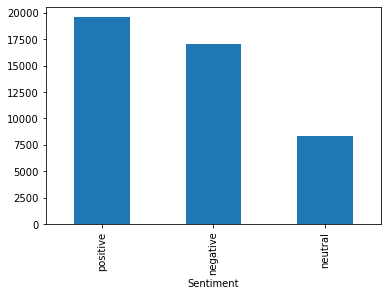

In [6]:
sentiment.plot(kind="bar", legend=None)

In [7]:
#wyświetl 100 rekordów
print(train.head(100))
#wyświetl informacje o zbiorze danych
print(train.describe())

    UserName  ScreenName                    Location     TweetAt  \
0       3799       48751                      London  16-03-2020   
1       3800       48752                          UK  16-03-2020   
2       3801       48753                   Vagabonds  16-03-2020   
3       3802       48754                         NaN  16-03-2020   
4       3803       48755                         NaN  16-03-2020   
..       ...         ...                         ...         ...   
95      3894       48846  FREE goal setting guide ??  16-03-2020   
96      3895       48847              Washington, DC  16-03-2020   
97      3896       48848              Washington, DC  16-03-2020   
98      3897       48849       San Joaquin Valley CA  16-03-2020   
99      3898       48850                Planet Earth  16-03-2020   

                                        OriginalTweet Sentiment  \
0   @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   neutral   
1   advice Talk to your neighbours family to exch

## 1.2 Analiza zbioru danych

In [8]:
#sprawdź liczbę słów w tweecie
train['word_count']=train['OriginalTweet'].apply(lambda x: len(str(x).split(" ")))
train[['OriginalTweet', 'word_count']].head(10)

,OriginalTweet,word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8
1,advice Talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,14
3,My food stock is not the only one which is emp...,40
4,"Me, ready to go at supermarket during the #COV...",38
5,As news of the regionÂs first confirmed COVID...,36
6,Cashier at grocery store was sharing his insig...,28
7,Was at the supermarket today. Didn't buy toile...,12
8,Due to COVID-19 our retail store and classroom...,46
9,"For corona prevention,we should stop to buy th...",42


In [9]:
#sprawdź ilość znaków
train['char_count']=train['OriginalTweet'].str.len()
train[['OriginalTweet', 'char_count']].head(10)

,OriginalTweet,char_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,111
1,advice Talk to your neighbours family to excha...,237
2,Coronavirus Australia: Woolworths to give elde...,131
3,My food stock is not the only one which is emp...,306
4,"Me, ready to go at supermarket during the #COV...",310
5,As news of the regionÂs first confirmed COVID...,250
6,Cashier at grocery store was sharing his insig...,180
7,Was at the supermarket today. Didn't buy toile...,119
8,Due to COVID-19 our retail store and classroom...,280
9,"For corona prevention,we should stop to buy th...",267


In [10]:
#sprawdź średnią długość słowa
def avg_word(sentence):
    words=sentence.split()
    return (sum(len(word) for word in words)/len(words))
train['avg_words'] = train['OriginalTweet'].apply(lambda x:avg_word(x))
train[['OriginalTweet', 'avg_words']].head(10)

,OriginalTweet,avg_words
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,13.000000
1,advice Talk to your neighbours family to excha...,5.263158
2,Coronavirus Australia: Woolworths to give elde...,8.428571
3,My food stock is not the only one which is emp...,6.000000
4,"Me, ready to go at supermarket during the #COV...",6.525000
5,As news of the regionÂs first confirmed COVID...,5.972222
6,Cashier at grocery store was sharing his insig...,5.464286
7,Was at the supermarket today. Didn't buy toile...,7.846154
8,Due to COVID-19 our retail store and classroom...,5.222222
9,"For corona prevention,we should stop to buy th...",5.380952


In [11]:
#policz ilość słów ze stoplisty
train['stopwords']=train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['OriginalTweet', 'stopwords']].head(10)

,OriginalTweet,stopwords
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,11
2,Coronavirus Australia: Woolworths to give elde...,1
3,My food stock is not the only one which is emp...,14
4,"Me, ready to go at supermarket during the #COV...",13
5,As news of the regionÂs first confirmed COVID...,8
6,Cashier at grocery store was sharing his insig...,9
7,Was at the supermarket today. Didn't buy toile...,2
8,Due to COVID-19 our retail store and classroom...,18
9,"For corona prevention,we should stop to buy th...",16


In [12]:
#policz ilość znaków specjalnych
specialPatt=r"[^a-zA-Z0-9 ]"
train['special_characters']=train['OriginalTweet'].str.findall(specialPatt)
train['special_characters']=train['special_characters'].apply(lambda x: len(x))
train[['OriginalTweet', 'special_characters']].head(10)

,OriginalTweet,special_characters
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,19
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,8
3,My food stock is not the only one which is emp...,37
4,"Me, ready to go at supermarket during the #COV...",35
5,As news of the regionÂs first confirmed COVID...,15
6,Cashier at grocery store was sharing his insig...,12
7,Was at the supermarket today. Didn't buy toile...,18
8,Due to COVID-19 our retail store and classroom...,12
9,"For corona prevention,we should stop to buy th...",8


In [13]:
#policz ilość znaków numerycznych
train['numerics'] = train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train[['OriginalTweet', 'numerics']].head(10)

,OriginalTweet,numerics
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",0
5,As news of the regionÂs first confirmed COVID...,0
6,Cashier at grocery store was sharing his insig...,0
7,Was at the supermarket today. Didn't buy toile...,0
8,Due to COVID-19 our retail store and classroom...,0
9,"For corona prevention,we should stop to buy th...",0


In [14]:
#policz słowa z wielką literą
train['upper_count'] = train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x.isupper]))
train[['OriginalTweet', 'upper_count']].head(10)

,OriginalTweet,upper_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8
1,advice Talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,14
3,My food stock is not the only one which is emp...,42
4,"Me, ready to go at supermarket during the #COV...",40
5,As news of the regionÂs first confirmed COVID...,36
6,Cashier at grocery store was sharing his insig...,28
7,Was at the supermarket today. Didn't buy toile...,13
8,Due to COVID-19 our retail store and classroom...,45
9,"For corona prevention,we should stop to buy th...",42


In [15]:
train.corr()

,UserName,ScreenName,word_count,char_count,avg_words,stopwords,special_characters,numerics,upper_count
UserName,1.000000,1.000000,-0.077938,-0.048285,0.044671,-0.093281,-0.027700,0.060658,-0.080956
ScreenName,1.000000,1.000000,-0.077938,-0.048285,0.044671,-0.093281,-0.027700,0.060658,-0.080956
word_count,-0.077938,-0.077938,1.000000,0.853798,-0.354407,0.847810,0.096506,0.172068,0.988438
char_count,-0.048285,-0.048285,0.853798,1.000000,-0.054861,0.601460,0.472355,0.038452,0.880358
avg_words,0.044671,0.044671,-0.354407,-0.054861,1.000000,-0.420707,0.301650,-0.159020,-0.343619
stopwords,-0.093281,-0.093281,0.847810,0.601460,-0.420707,1.000000,-0.121965,0.090218,0.843203
special_characters,-0.027700,-0.027700,0.096506,0.472355,0.301650,-0.121965,1.000000,-0.160979,0.164690
numerics,0.060658,0.060658,0.172068,0.038452,-0.159020,0.090218,-0.160979,1.000000,0.163199
upper_count,-0.080956,-0.080956,0.988438,0.880358,-0.343619,0.843203,0.164690,0.163199,1.000000


# 2. Normalizacja danych tekstowych

In [16]:
#kopia bez normalizacji
trainDFRaw = train.copy()
#usuń słowa z wielką literą
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https://t.co/i...
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
3    my food stock is not the only one which is emp...
4    me, ready to go at supermarket during the #cov...
5    as news of the regionâs first confirmed covid...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today. didn't buy toile...
8    due to covid-19 our retail store and classroom...
9    for corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

In [17]:
#usuń wszystkie znaki specjalne poza białymi
train['OriginalTweet'] = train['OriginalTweet'].str.replace("[^\w\s]", '')
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
5    as news of the regionâs first confirmed covid1...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today didnt buy toilet ...
8    due to covid19 our retail store and classroom ...
9    for corona preventionwe should stop to buy thi...
Name: OriginalTweet, dtype: object

In [18]:
#usuń słowa z ze stop listy
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please dont panic enough ...
4    ready go supermarket covid19 outbreak im paran...
5    news regionâs first confirmed covid19 case cam...
6    cashier grocery store sharing insights covid_1...
7    supermarket today didnt buy toilet paper rebel...
8    due covid19 retail store classroom atlanta ope...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [19]:
#przeanalizuj frazy najczęściej występujące
freq=pd.Series(' '.join(train['OriginalTweet']).split()).value_counts()[:5]
freq

coronavirus    19460
covid19        14551
food            8359
prices          8313
store           7784
dtype: int64

In [20]:
#usuń słowa najczęściej występujące
freq=list(freq.index)
train['OriginalTweet']= train['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak im paranoid stoc...
5    news regionâs first confirmed case came sulliv...
6    cashier grocery sharing insights covid_19 prov...
7    supermarket today didnt buy toilet paper rebel...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [21]:
#przeanalizuj słowa najrzadziej występujące
leastFreq=pd.Series(' '.join(train['OriginalTweet']).split()).value_counts()[-30:]
leastFreq

httpstcovtwmdrwand    1
maslowâs              1
guanguancnsphoto      1
httpstcosriqojebat    1
insurersâ             1
httpstcor07dxkdsot    1
jine                  1
httpstcoyjoi5eleat    1
billywizztransport    1
postcovidworld        1
xfiles                1
httpstcol8rvolobdx    1
fueloil               1
794                   1
nashvilles            1
crossisle             1
6250                  1
httpstcoehjyv98fpa    1
paidsocialmedia       1
counterregressive     1
dispatches            1
furnace               1
sponsoredâ            1
httpstcouiwoansr4x    1
httpstcok3rkuz4jzm    1
visas                 1
evp                   1
httpstcowueexedhjp    1
httpstcoa9rxvwz17g    1
abiv                  1
dtype: int64

In [22]:
#usuń słowa najrzadziej występujące
leastFreq= list(leastFreq.index)
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in leastFreq))
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak im paranoid stoc...
5    news regionâs first confirmed case came sulliv...
6    cashier grocery sharing insights covid_19 prov...
7    supermarket today didnt buy toilet paper rebel...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [23]:
#popraw pisowanię, popraw literówki
train['OriginalTweet'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    menyrbie phil_gahan christ httpstcoifz9fan2pa ...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak in paranoid stoc...
Name: OriginalTweet, dtype: object

In [24]:
#lematyzacja - zamiana słów na ich podstawową formę
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbour family exchange phone nu...
2    australia woolworth give elderly disabled dedi...
3    stock one empty please dont panic enough every...
4    ready go supermarket outbreak im paranoid stoc...
5    news regionâs first confirmed case came sulliv...
6    cashier grocery sharing insight covid_19 prove...
7    supermarket today didnt buy toilet paper rebel...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy thing cash use on...
Name: OriginalTweet, dtype: object

# 2.1 Wektoryzacja

In [25]:
tf1 = (train['OriginalTweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,number,2
1,phone,2
2,neighbour,2
3,regular,1
4,family,1
5,online,1
6,gp,1
7,adequate,1
8,exchange,1
9,chemist,1


In [26]:
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(train.shape[0]/(len(train[train['OriginalTweet'].str.contains(word)])))
tf1

,words,tf,idf
0,number,2,4.689970
1,phone,2,5.082205
2,neighbour,2,6.003887
3,regular,1,5.271000
4,family,1,3.824845
5,online,1,2.477792
6,gp,1,4.789161
7,adequate,1,6.762174
8,exchange,1,6.602543
9,chemist,1,6.586283


In [27]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,number,2,4.689970,9.379939
1,phone,2,5.082205,10.164411
2,neighbour,2,6.003887,12.007774
3,regular,1,5.271000,5.271000
4,family,1,3.824845,3.824845
5,online,1,2.477792,2.477792
6,gp,1,4.789161,4.789161
7,adequate,1,6.762174,6.762174
8,exchange,1,6.602543,6.602543
9,chemist,1,6.586283,6.586283


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(train['OriginalTweet'])

train_vect

<44955x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 406346 stored elements in Compressed Sparse Row format>

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(train['OriginalTweet'])
train_bow

<44955x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 453267 stored elements in Compressed Sparse Row format>

In [30]:
train['sentiment'] = train['OriginalTweet'].apply(lambda x: TextBlob(x).sentiment[0])
train[['OriginalTweet', 'sentiment']].head()

,OriginalTweet,sentiment
0,menyrbie phil_gahan chrisitv httpstcoifz9fan2p...,0.000000
1,advice talk neighbour family exchange phone nu...,0.166667
2,australia woolworth give elderly disabled dedi...,-0.200000
3,stock one empty please dont panic enough every...,0.175000
4,ready go supermarket outbreak im paranoid stoc...,-0.077778


In [32]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [33]:
from gensim.models import KeyedVectors 
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [34]:
tweets=np.array(train['OriginalTweet'])
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets)

vectorizer.get_feature_names()

['00',
 '000',
 '0000009375',
 '000042',
 '0000hrs',
 '0006',
 '000francs',
 '000s',
 '001',
 '0010',
 '0016',
 '0017âkwh',
 '0025450557',
 '0026691661',
 '005',
 '00541296',
 '0095',
 '00am',
 '00pm',
 '01',
 '010',
 '0100am',
 '0101',
 '0103641972',
 '0106',
 '0113',
 '0115',
 '012020',
 '0121',
 '01236',
 '01273',
 '0131',
 '01392576476infoswcommsenergycouk',
 '014',
 '01449',
 '0147',
 '01474',
 '01625',
 '0169061211',
 '017569',
 '01756986',
 '0175698634',
 '01765',
 '01892',
 '01952',
 '01hr',
 '01kg',
 '02',
 '020',
 '0200hrs',
 '02027790000202628233',
 '0203',
 '02037386000',
 '0207pm',
 '021111000162',
 '0214996028',
 '02268443322',
 '023',
 '024p',
 '025',
 '0258',
 '025pc',
 '027',
 '028',
 '02890391225',
 '029',
 '02920',
 '03',
 '0300',
 '0300pm',
 '03031239999',
 '03065659733',
 '03162020',
 '031820',
 '0319',
 '03202020',
 '032320',
 '03237979660',
 '03252020',
 '0330',
 '03338819977',
 '03344859556',
 '0337210852',
 '034',
 '0344',
 '0345',
 '03454',
 '0351',
 '036',
 '

# 3. Przygotowanie modelu

# Dane treningowe i testowe

In [35]:
#podział zbioru na dane testowe i treningowe
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train['OriginalTweet'], train['Sentiment'])

#zmiana etykiet na numeryczne
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
train_y.shape, train_x.shape

((33716,), (33716,))

# Liczba wystąpień słowa w tekście

In [36]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train['OriginalTweet'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)
print(xtrain_count)

  (0, 923)	1
  (0, 4226)	2
  (0, 11574)	1
  (0, 13000)	2
  (0, 44613)	1
  (0, 60593)	1
  (0, 63309)	1
  (0, 73610)	2
  (0, 74322)	2
  (0, 79324)	1
  (1, 4491)	1
  (1, 9905)	1
  (1, 10008)	1
  (1, 10611)	1
  (1, 13992)	1
  (1, 23100)	1
  (1, 25557)	1
  (1, 25571)	1
  (1, 26051)	1
  (1, 40563)	1
  (1, 63309)	1
  (1, 67211)	1
  (1, 74448)	1
  (1, 78604)	1
  (1, 80748)	1
  :	:
  (33714, 4752)	3
  (33714, 7613)	1
  (33714, 8827)	1
  (33714, 13000)	1
  (33714, 13204)	1
  (33714, 15226)	1
  (33714, 17039)	1
  (33714, 19024)	1
  (33714, 26051)	1
  (33714, 26170)	1
  (33714, 40165)	1
  (33714, 58134)	1
  (33714, 60508)	1
  (33714, 63121)	1
  (33714, 68399)	1
  (33714, 69413)	2
  (33714, 71446)	1
  (33714, 80748)	1
  (33714, 82574)	1
  (33714, 83814)	1
  (33715, 26281)	1
  (33715, 71878)	1
  (33715, 74505)	1
  (33715, 76069)	1
  (33715, 86497)	1


# Częstotliwość faz i odwrócona częstotliwość faz

In [37]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train['OriginalTweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(train['OriginalTweet'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(train['OriginalTweet'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


# Kodowanie słów

In [39]:
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec', encoding="utf-8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

token = text.Tokenizer()
token.fit_on_texts(train['OriginalTweet'])
word_index = token.word_index

train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# NLP features - liczba słów, liter, znaków interpunkcyjnych, słów z wielkimi literami, zaczynąjących się od wielkiej litery i średnia długiść słów

In [40]:
train['char_count'] = train['OriginalTweet'].apply(len)
train['word_count'] = train['OriginalTweet'].apply(lambda x: len(x.split()))
train['word_density'] = train['char_count'] / (train['word_count']+1)
train['punctuation_count'] = train['OriginalTweet'].apply(
    lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train['title_word_count'] = train['OriginalTweet'].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train['upper_case_word_count'] = train['OriginalTweet'].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

# Liczba rzeczowników, czasowników, przymiotników, przysłówków i zaimków

In [41]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adjective' :  ['JJ','JJR','JJS'],
    'adverb' : ['RB','RBR','RBS','WRB'],
    'pronoun' : ['PRP','PRP$','WP','WP$']
}

def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

train['noun_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'noun'))
train['verb_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'verb'))
train['adjective_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'adjective'))
train['adverb_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'adverb'))
train['pronoun_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'pronoun'))

In [42]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,word_count,char_count,avg_words,...,sentiment,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adjective_count,adverb_count,pronoun_count
0,3799,48751,London,16-03-2020,menyrbie phil_gahan chrisitv httpstcoifz9fan2p...,neutral,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,6,85,13.000000,...,0.000000,12.142857,1,0,0,6,0,0,0,0
1,3800,48752,UK,16-03-2020,advice talk neighbour family exchange phone nu...,positive,advice Talk to your neighbours family to excha...,27,185,5.263158,...,0.166667,6.607143,0,0,0,17,4,4,0,0
2,3801,48753,Vagabonds,16-03-2020,australia woolworth give elderly disabled dedi...,positive,Coronavirus Australia: Woolworths to give elde...,11,98,8.428571,...,-0.200000,8.166667,0,0,0,3,5,2,0,0
3,3802,48754,NaN,16-03-2020,stock one empty please dont panic enough every...,positive,My food stock is not the only one which is emp...,20,168,6.000000,...,0.175000,8.000000,1,0,0,9,3,6,1,0
4,3803,48755,NaN,16-03-2020,ready go supermarket outbreak im paranoid stoc...,negative,"Me, ready to go at supermarket during the #COV...",21,185,6.525000,...,-0.077778,8.409091,0,0,0,12,2,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,meanwhile supermarket israel people dance sing...,positive,Meanwhile In A Supermarket in Israel -- People...,10,88,6.111111,...,0.227273,8.000000,0,0,0,4,2,2,2,0
3794,3795,48747,"Farmington, NM",16-03-2020,panic buy lot nonperishable item echo need don...,negative,Did you panic buy a lot of non-perishable item...,18,131,5.294118,...,0.500000,6.894737,0,0,0,11,3,3,1,0
3795,3796,48748,"Haverford, PA",16-03-2020,asst prof economics cconces nbcphiladelphia ta...,neutral,Asst Prof of Economics @cconces was on @NBCPhi...,14,119,6.153846,...,0.000000,7.933333,0,0,0,8,3,1,1,0
3796,3797,48749,NaN,16-03-2020,gov need somethings instead biar je rakyat ass...,negative,Gov need to do somethings instead of biar je r...,24,154,5.034483,...,-1.000000,6.160000,0,0,0,12,6,1,2,0


# Modelowanie abstrakcyjnych tematów

In [43]:
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
print(topic_summaries)

['19 covid consumer crisis pandemic way right country u outbreak', 'supermarket people grocery covid_19 get need panic go shopping home', 'spread make response amazon panicbuying great able sanitizers sure fight', 'hand sanitizer getting tesco information soap wash issue result alcohol', 'service world enough taking retailer cost new kind concern case', 'providing distillery kitchen remains plummet damage cool girl steel scarce', 'donât restaurant never etc water coronavirusoutbreak cut selling stock drive', 'toilet paper toiletpaper quarantine state shortage roll closed still hope', 'oil gas continue measure together low nothing lower economy morning', 'say would social retail online read consumer via check distancing', 'vulnerable le looking might surge closure following caused buyer baby', 'demand supply amp essential government bank price chain open pandemic', 'help staff product risk come coronacrisis time new community news', '2 online use 1 shopping 3 job money 4 friend', 'marke

# Modelowanie uczenia maszynowego

## Medoda sprawdzająca dokładność modelu

In [44]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    # dokonaj ewaluacji modelu na podstawie danych testowych
    scores = list(metrics.precision_recall_fscore_support(predictions, valid_y))
    score_vals = [
        scores[0][0],
        scores[1][0],
        scores[2][0]
    ]
    score_vals.append(metrics.accuracy_score(predictions, valid_y))
    return score_vals

## Naiwny klasyfikator Bayesowski

In [45]:
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab = {'NB':accuracy}
print ("NB, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  [0.7402506963788301, 0.6750635055038103, 0.7061558901682906, 0.6704333125722929]
NB, WordLevel TF-IDF:  [0.7221448467966574, 0.7019404332129964, 0.7118993135011441, 0.67434825162381]
NB, N-Gram Vectors:  [0.510213556174559, 0.5787256450763559, 0.542314335060449, 0.5456891182489545]
NB, CharLevel Vectors:  [0.5921541318477251, 0.6547741273100616, 0.6218917601170161, 0.6118871785746063]


## Klasyfikator liniowy

In [46]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab['LR'] =  accuracy
print ("LR, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, Count Vectors:  [0.7964252553389044, 0.8215996168582376, 0.8088165959453089, 0.7976688317465966]


C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, WordLevel TF-IDF:  [0.8006035283194057, 0.8009753831862517, 0.8007894125841651, 0.7912625678441142]


C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, N-Gram Vectors:  [0.5153203342618384, 0.5905826017557861, 0.5503904797322424, 0.5491591778627992]
LR, CharLevel Vectors:  [0.7209842154131848, 0.7135308982311049, 0.7172381942039024, 0.7055787881484118]


C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Klasyfikator Support Vector Machine

In [47]:
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy_compareTab['SVM'] =  accuracy
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  [0.6299907149489322, 0.5165588123334602, 0.5676636686885589, 0.5470237565619717]


## Klasyfikator Random Forrest, modele agregujące

In [48]:
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)

accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab['RF'] =  accuracy
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  [0.7330547818012999, 0.7895, 0.7602311025517574, 0.7643028739211674]
RF, WordLevel TF-IDF:  [0.7263231197771588, 0.7693631669535284, 0.7472238805970148, 0.7500667319156509]


## Klasyfikator Extreme Boosting

In [49]:
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
accuracy_compareTab['Xgb'] =  accuracy
print ("Xgb, CharLevel Vectors: ", accuracy)

C:\Users\mxnog\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:03:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, Count Vectors:  [0.739322191272052, 0.7950574138791813, 0.7661775318739477, 0.7693744995106326]
[18:03:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, WordLevel TF-IDF:  [0.7490714948932219, 0.7751621426855633, 0.7618935190650455, 0.7619005249577364]
[18:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the

## Płytkie sieci neuronowe

In [50]:
def create_model_architecture(input_size):
    input_layer = layers.Input((input_size, ), sparse=True)

    hidden_layer = layers.Dense(100, activation="relu")(input_layer)

    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)
accuracy_compareTab['NN'] =  accuracy
print ("NN, Ngram Level TF IDF Vectors",  accuracy)

1054/1054 [==============================] - 6s 5ms/step - loss: -1.6302
NN, Ngram Level TF IDF Vectors [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319]


C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Głębokie sieci neuronowe

### Konwulcyjne sieci neuronowe

In [51]:
def create_cnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['CNN'] =  accuracy
print ("CNN, Word Embeddings",  accuracy)

1054/1054 [==============================] - 15s 14ms/step - loss: -1193.7465
CNN, Word Embeddings [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319]


### Long Short Term Model

In [52]:
def create_rnn_lstm():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.LSTM(100)(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings",  accuracy)
accuracy_compareTab['RNN-LSTM'] =  accuracy

1054/1054 [==============================] - 42s 40ms/step - loss: -13.6379
RNN-LSTM, Word Embeddings [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319]


### Granted Recurrent Unit

In [53]:
def create_rnn_gru():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.GRU(100)(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['RNN-GRU'] =  accuracy
print ("RNN-GRU, Word Embeddings",  accuracy)

1054/1054 [==============================] - 46s 44ms/step - loss: -12.7028
RNN-GRU, Word Embeddings [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319]


### Dwukierunkowe sieci neuronowe

In [54]:
def create_bidirectional_rnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['RNN-Bidirectional'] =  accuracy
print ("RNN-Bidirectional, Word Embeddings",  accuracy)

1054/1054 [==============================] - 55s 52ms/step - loss: -160.0969
RNN-Bidirectional, Word Embeddings [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319]


### Rekurencyjne konwolucyjne sieci neuronowe

In [55]:
def create_rcnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['RCNN'] =  accuracy
print ("RCNN, Word Embeddings",  accuracy)

1054/1054 [==============================] - 13s 12ms/step - loss: -1088.3118
RCNN, Word Embeddings [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319]


In [56]:
print(accuracy_compareTab)
accuracy_compareTab2 = accuracy_compareTab.copy()
print(accuracy_compareTab2)

{'NB': [0.7221448467966574, 0.7019404332129964, 0.7118993135011441, 0.67434825162381], 'LR': [0.8006035283194057, 0.8009753831862517, 0.8007894125841651, 0.7912625678441142], 'SVM': [0.6299907149489322, 0.5165588123334602, 0.5676636686885589, 0.5470237565619717], 'RF': [0.7263231197771588, 0.7693631669535284, 0.7472238805970148, 0.7500667319156509], 'Xgb': [0.7228412256267409, 0.7245230339692881, 0.7236811526841738, 0.7163448705400837], 'NN': [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319], 'CNN': [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319], 'RNN-LSTM': [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319], 'RNN-GRU': [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319], 'RNN-Bidirectional': [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319], 'RCNN': [1.0, 0.3833081234985319, 0.5541905190712034, 0.3833081234985319]}
{'NB': [0.7221448467966574, 0.7019404332129964, 0.7118993135011441, 0.67434825162381], 'LR':

# 4.Ewaluacja modeli

In [57]:
%matplotlib notebook

<IPython.core.display.Javascript object>


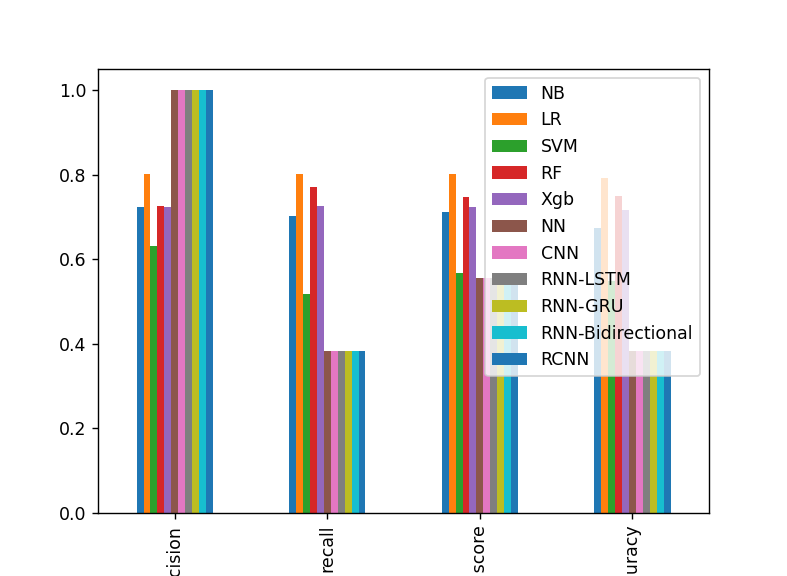

In [58]:
df_compare = pd.DataFrame(accuracy_compareTab, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare.plot(kind='bar')

## Dane bez normalizacji tekstu

In [59]:
#podział zbioru na dane testowe i treningowe
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDFRaw['OriginalTweet'], trainDFRaw['Sentiment'])

#zmiana etykiet na numeryczne
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDFRaw['OriginalTweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDFRaw['OriginalTweet'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDFRaw['OriginalTweet'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Klasyfikatory

In [60]:
#NB
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab2 = {'NBRaw':accuracy}

In [61]:
#LR
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab2['LRRaw'] =  accuracy

C:\Users\mxnog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
#SVM
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy_compareTab2['SVMRaw'] =  accuracy

In [63]:
#RF
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab2['RFRaw'] =  accuracy

In [64]:
#Xgb
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
accuracy_compareTab2['XgbRaw'] =  accuracy

C:\Users\mxnog\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>


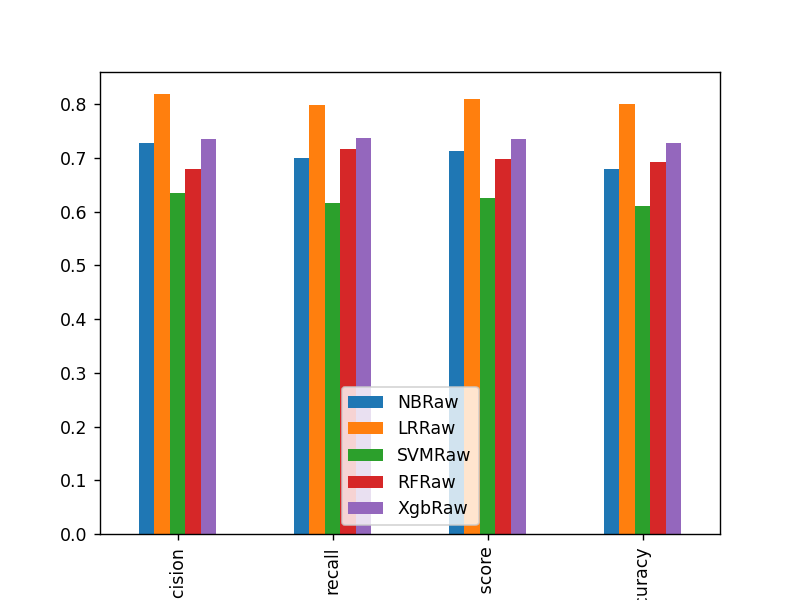

In [65]:
df_compare2 = pd.DataFrame(accuracy_compareTab2, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare2.plot(kind='bar')